# HW1

In [ ]:
Username:Dongkai Fang
Username:DongkaiFang1021
USC ID:5008857028

### (a) Download Data

Package imports

In [17]:
import numpy as np
import pandas as pd

Get the Vertebral Column Data Set

In [18]:
df = pd.read_csv("./vertebral+column/column_3C.dat", sep=r'\s+', header=None)
df.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
              'sacral_slope', 'pelvic_radius', 'spondylolisthesis', 'class']
# Binary classification
df['class'] = df['class'].apply(lambda x: 0 if x == 'NO' else 1)
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1


### (b) Pre-Processing and Exploratory Data Analysis

#### i. Scatterplots

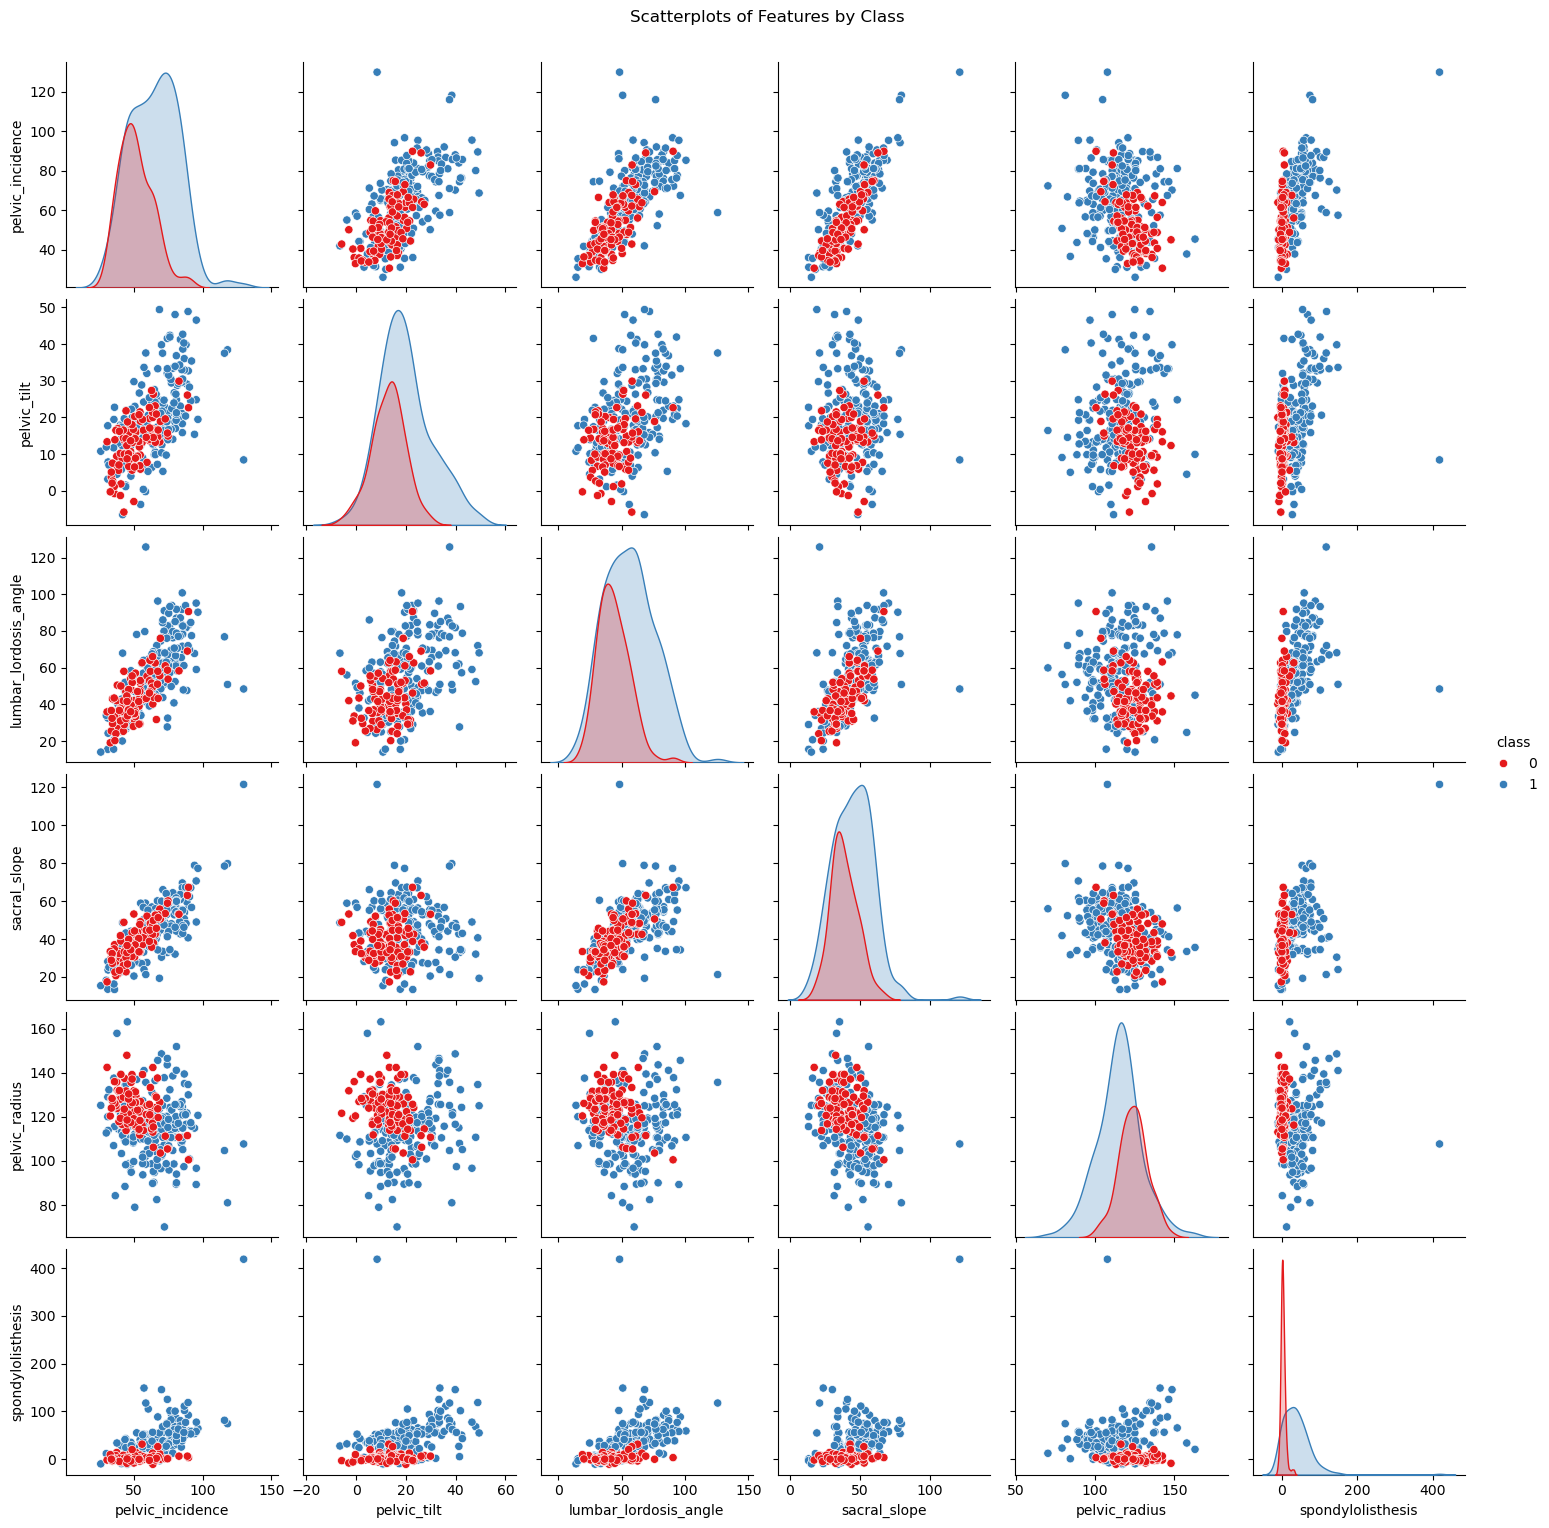

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df, hue='class', palette='Set1')
plt.suptitle('Scatterplots of Features by Class', y=1.02)
plt.show()

#### ii. Boxplots

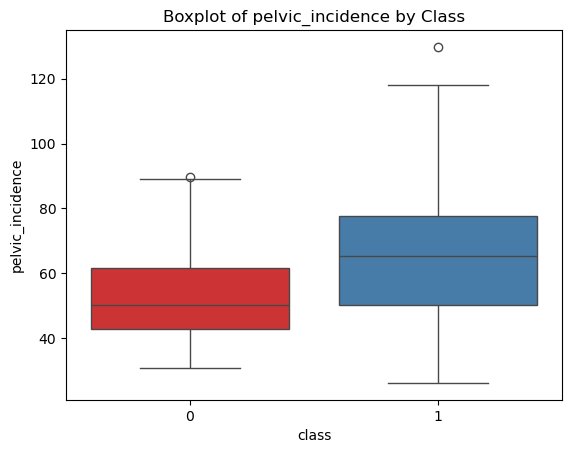

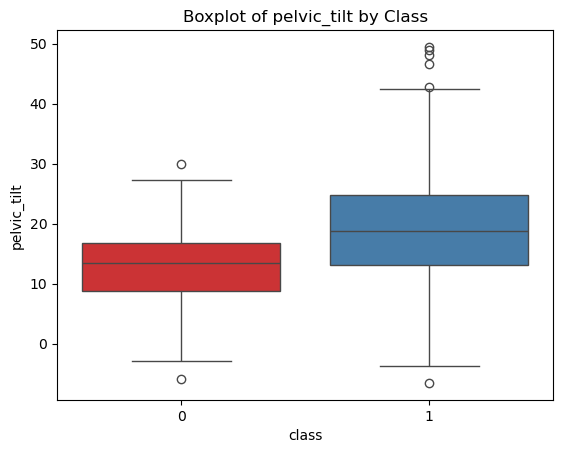

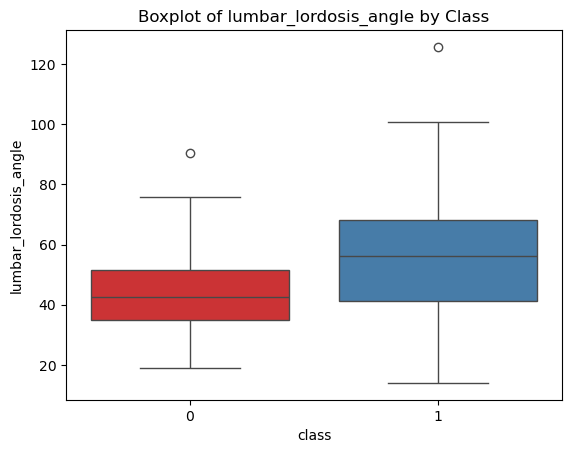

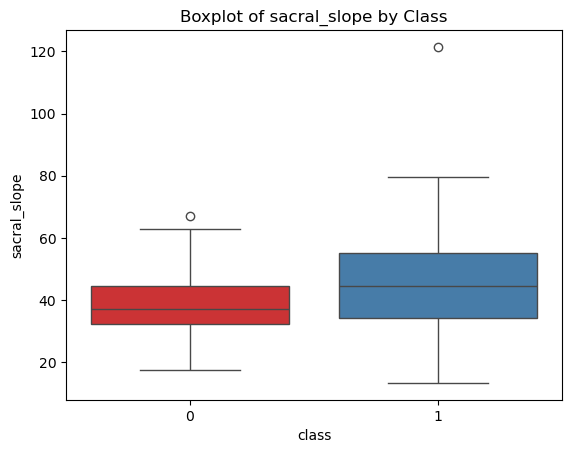

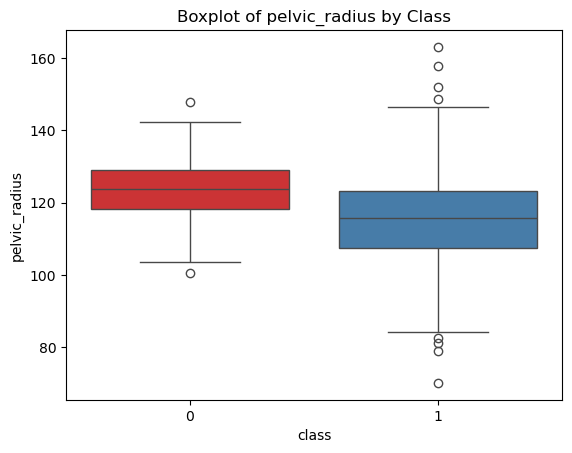

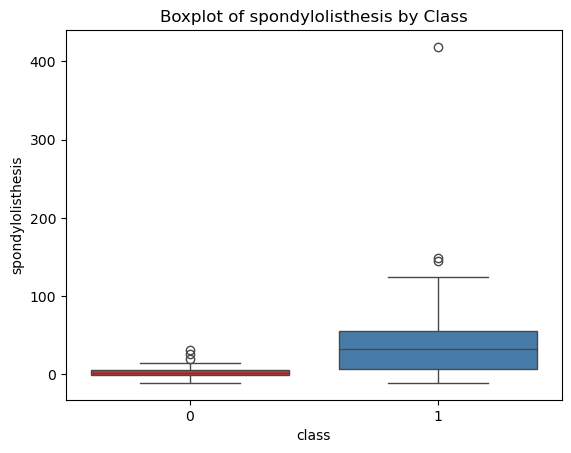

In [5]:
for col in df.columns[:-1]:
    sns.boxplot(x='class', y=col, data=df, hue='class', palette='Set1', legend=False)
    plt.title(f'Boxplot of {col} by Class')
    plt.show()

#### iii. Split Data Set

In [6]:
# Extract features and labels
X = df.iloc[:, :-1].values
y = df['class'].values
# Separate normal and abnormal classes
X_normal = X[y == 0]
X_abnormal = X[y == 1]
y_normal = y[y == 0]
y_abnormal = y[y == 1]
# Use first 70 normal and 140 abnormal for training
X_train = np.vstack((X_normal[:70], X_abnormal[:140]))
y_train = np.concatenate((y_normal[:70], y_abnormal[:140]))
# The rest for testing
X_test = np.vstack((X_normal[70:], X_abnormal[140:]))
y_test = np.concatenate((y_normal[70:], y_abnormal[140:]))

### (c) Classification

#### i. Euclidean Metric

In [7]:
from sklearn.neighbors import KNeighborsClassifier
# KNN classifier with Euclidean distance
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

#### ii. Test Data

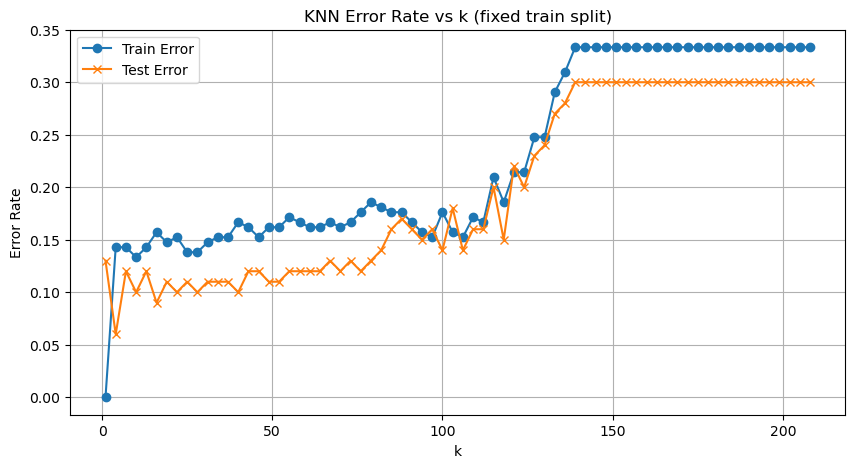

Best k* = 4
Confusion Matrix:
 [[25  5]
 [ 1 69]]
True Positive Rate (Recall): 0.9857
True Negative Rate: 0.8333
Precision: 0.9324
F1 Score: 0.9583


In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
k_values = list(range(208, 0, -3))
train_errors = []
test_errors = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    train_errors.append(1 - knn.score(X_train, y_train))
    test_errors.append(1 - knn.score(X_test, y_test))
# Plot train/test error vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, train_errors, label='Train Error', marker='o')
plt.plot(k_values, test_errors, label='Test Error', marker='x')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title('KNN Error Rate vs k (fixed train split)')
plt.legend()
plt.grid()
plt.show()
# Best k
best_k_index = np.argmin(test_errors)
best_k = k_values[best_k_index]
print(f"Best k* = {best_k}")
# === Metrics at k* ===
knn_best = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TPR = TP / (TP + FN)  # Recall
TNR = TN / (TN + FP)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(f"True Positive Rate (Recall): {TPR:.4f}")
print(f"True Negative Rate: {TNR:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

#### iii. Learning Curve

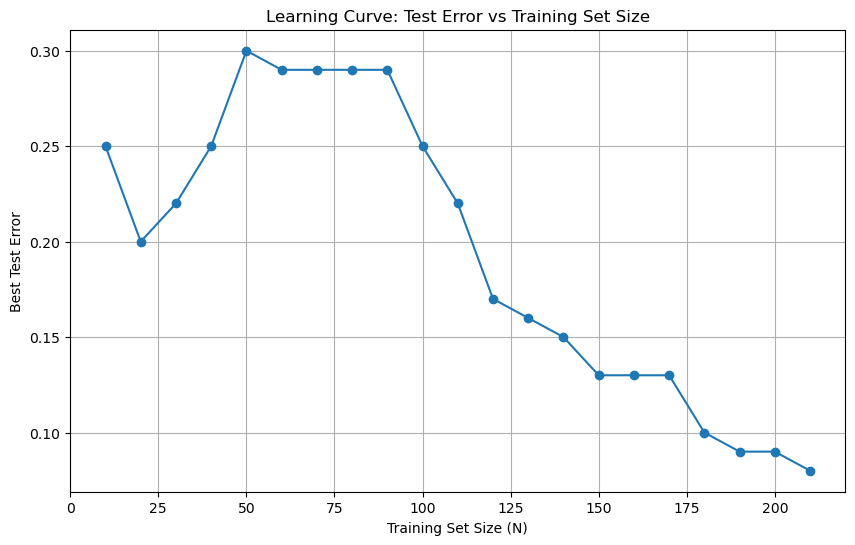

In [9]:
N_values = range(10, 211, 10)
best_test_errors = []
for N in N_values:
    n_class0 = N // 3
    n_class1 = N - n_class0
    X_train = np.vstack((X_normal[:n_class0], X_abnormal[:n_class1]))
    y_train = np.concatenate((y_normal[:n_class0], y_abnormal[:n_class1]))
    k_candidates = list(range(1, N - 2, 5)) if N >= 5 else [1]
    min_test_error = 1.0
    for k in k_candidates:
        if k >= len(X_train):
            continue  # k must be less than number of training samples
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train, y_train)
        test_error = 1 - knn.score(X_test, y_test)
        if test_error < min_test_error:
            min_test_error = test_error
    best_test_errors.append(min_test_error)
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(N_values, best_test_errors, marker='o')
plt.xlabel('Training Set Size (N)')
plt.ylabel('Best Test Error')
plt.title('Learning Curve: Test Error vs Training Set Size')
plt.grid()
plt.show()

### (d) Other Metrics

#### i. Minkowski Distance.

##### A. Manhattan Distance with p = 1.

In [10]:
k_values = list(range(1, 197, 5))
results = {}
min_err, best_k = 1.0, None
for k in k_values:
    if k < len(X_train):
        knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
        knn.fit(X_train, y_train)
        err = 1 - knn.score(X_test, y_test)
        if err < min_err:
            min_err = err
            best_k = k
results['Manhattan (p=1)'] = (min_err, best_k)

##### B. With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [11]:
logp_values = np.arange(0.1, 1.1, 0.1)
min_err_logp, best_logp = 1.0, None
for logp in logp_values:
    p = 10 ** logp
    knn = KNeighborsClassifier(n_neighbors=best_k, metric='minkowski', p=p)
    knn.fit(X_train, y_train)
    err = 1 - knn.score(X_test, y_test)
    if err < min_err_logp:
        min_err_logp = err
        best_logp = logp
results[f'Minkowski (log10(p)={best_logp:.1f})'] = (min_err_logp, best_k)

##### C. Chebyshev Distance With p -> infinity.

In [12]:
min_err, best_k_cheb = 1.0, None
for k in k_values:
    if k < len(X_train):
        knn = KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
        knn.fit(X_train, y_train)
        err = 1 - knn.score(X_test, y_test)
        if err < min_err:
            min_err = err
            best_k_cheb = k
results['Chebyshev'] = (min_err, best_k_cheb)

#### ii. Mahalanobis Distance.

In [13]:
from numpy.linalg import pinv
VI = pinv(np.cov(X_train.T))
min_err, best_k_mah = 1.0, None
for k in k_values:
    if k < len(X_train):
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric='mahalanobis',
            metric_params={'VI': VI}
        )
        knn.fit(X_train, y_train)
        err = 1 - knn.score(X_test, y_test)
        if err < min_err:
            min_err = err
            best_k_mah = k
results['Mahalanobis'] = (min_err, best_k_mah)

In [14]:
results_df = pd.DataFrame([
    {'Distance Metric': k, 'Best k': v[1], 'Test Error': v[0]}
    for k, v in results.items()
])
results_df

,Distance Metric,Best k,Test Error
0,Manhattan (p=1),6,0.11
1,Minkowski (log10(p)=0.6),6,0.06
2,Chebyshev,16,0.08
3,Mahalanobis,1,0.17


### (e) Weighted Decision

In [15]:
from sklearn.metrics import accuracy_score
results_weighted = {}
for metric in ['euclidean', 'manhattan', 'chebyshev']:
    min_err = 1.0
    best_k = None
    for k in k_values:
        if k < len(X_train):
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights='distance')
            knn.fit(X_train, y_train)
            err = 1 - knn.score(X_test, y_test)
            if err < min_err:
                min_err = err
                best_k = k
    results_weighted[metric.capitalize() + '_weighted'] = (min_err, best_k)
print("Weighted KNN Test Errors and Best k for Different Distance Metrics:")
for metric_name, (error, best_k) in results_weighted.items():
    print(f"{metric_name}: Best k = {best_k}, Test Error = {error:.4f}")

Weighted KNN Test Errors and Best k for Different Distance Metrics:
Euclidean_weighted: Best k = 6, Test Error = 0.1000
Manhattan_weighted: Best k = 26, Test Error = 0.1000
Chebyshev_weighted: Best k = 16, Test Error = 0.1100


### (f) Training Error Rate

In [16]:
lowest_train_error = 1.0
best_train_params = None
distance_metrics = ['euclidean', 'manhattan', 'chebyshev', 'mahalanobis']
for metric in distance_metrics:
    for k in k_values:
        if k < len(X_train):
            if metric == 'mahalanobis':
                knn = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': VI})
            else:
                knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train, y_train)
            train_err = 1 - knn.score(X_train, y_train)
            if train_err < lowest_train_error:
                lowest_train_error = train_err
                best_train_params = (metric, k)
print("\n==== Lowest Training Error ====")
print(f"Metric: {best_train_params[0]}, k = {best_train_params[1]}, Training Error = {lowest_train_error}")


==== Lowest Training Error ====
Metric: euclidean, k = 1, Training Error = 0.0


Lowest Training Error
    
    Metric: euclidean, k = 1, Training Error = 0.0